# Quantum tunneling examples

A few years ago [I invented](https://arundquist.wordpress.com/2020/08/15/fast-quantum-tunneling-method/) (I think) a new way to calculate quantum tunneling probabilities.

In this post I wanted to play around a little with some different scenarios to try to gain a little more insight.

## The method

There are three regions to consider. Before the barrier, inside the barrier region, and after the barrier. I say "region" there instead of just "in the barrier" because I might consider potential shapes that include pockets where you'd have positive kinetic energy.

In region one you have both a right and left traveling wave:

$$
\psi_I(x)=A_1e^{i k_1 x}+B_1e^{-i k_1 x}
$$

where $k_I$ is just $2\pi/\lambda$ or $p/\hbar$ for the momentum in that region. Since $\text{KE}=p^2/2m$ and since we'll assume the potential is zero in that region, you can also express $k_1$ as

$$
k_1=\sqrt{\frac{2m}{\hbar^2}E}
$$

In region three you have a similar situation, except you only have a right going wave:

$$
\psi_3(x)=A_3e^{i k_3 x}
$$

Since again we'll assume the potential is zero in that region, $k_3=k_1$.

In region two you can't say that the wavefunction has that same form, since $k$ is not a constant. That's easiest to understand if you first consider a constant barrier. In that case you would have that same right- and left-traveling wave but now $k_2$ would be given by:

$$
k_2=\sqrt{\frac{2m}{\hbar^2}(E-V)}
$$

where $V$ is the (constant) potential energy of the barrier. But for more complicated barriers, you can see that $k_2$ would not be constant. In this method, we simply have the ODE solver figure out what the wave function in region two is, using the known structure of regions one and three to help with boundary conditions.

In this method we arbitrarily set $A_3$ to one, realize that both the value and slope of the function just inside of the right side of the barrier is determined by $A_3$, then integrate back to just inside the left side, then use the continuity of value and slope again to figure out $A_1$ and $B_1$. Once we have that, the tunneling probability is easily found by the ratio of $A_3$ and $A_1$.

## Units

As is often the case with quantum tunneling, I'm going to choose to use eV for energy units and nm for space units. The trick when determining the value of various constants (like the mass of the electron or $\hbar$) is to pepper in factors of the speed of light wherever you can to make things easy. Specifically you're aiming to use one of these:

- $\hbar c=197$
- $mc^2=511,000$

Therefore you can do this:

$$
\frac{\hbar^2}{2m}=\frac{\hbar^2c^2}{2mc^2}=\frac{197^2}{2\times511000}
$$

and you're off!

# Helper functions

In [4]:
k[energy_]:=Sqrt[2 511000/197^2 energy]
k[1.0]

5.13168

Here I code in the ode step and the calculation of the transmission percent given by $T=4/\left|\psi(0)-i\psi'(0)/k\right|^2$. Note that both the sol and transmission function are built to take pure functions for the potential.

In [21]:
sol[potential_,energy_, length_]:=First[NDSolve[{-197^2/(2 511000) psi''[x]+(potential[x]-energy) psi[x]==0,
                                    psi[length]==Exp[I k[energy] length],
                                    psi'[length]==I k[energy] Exp[I k[energy] length]},{psi},{x,0,length}]];
transmission[potential_,energy_,length_]:=(s=sol[potential, energy, length];
                                            4/Abs[psi[0]-I psi'[0]/k[energy]]^2/.s)
transmission[5&,4.9,1]

0.0130511

Here I plot the transmission for a flat barrier of height 5 eV for energies ranging from zero to twice the barrier height:

-Graphics-
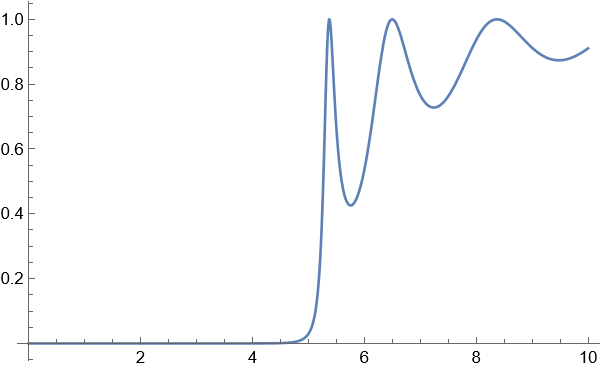

In [26]:
Plot[transmission[5&,energy,1],{energy,0,10}]

Here's the standard analytical result for a square barrier:

In [43]:
squaretransmission[e_, u_, d_]:=Chop[1/(1+1/4(u^2/(e(u-e))) Sinh[-I k[e-u] d]^2)];
squaretransmission[4.0,5,1]

0.0000893129

-Graphics-
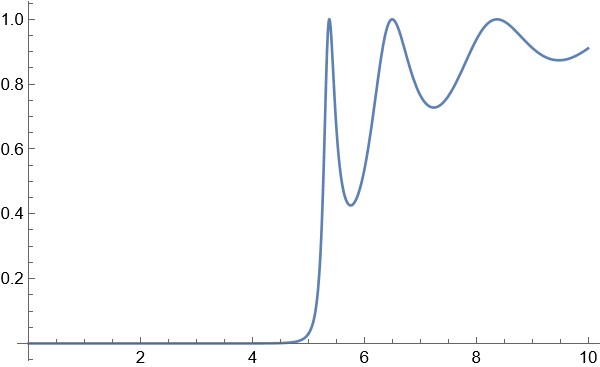

In [45]:
Plot[squaretransmission[e,5,1],{e,0,10}]

and here's a plot of the difference between the two approaches:

-Graphics-
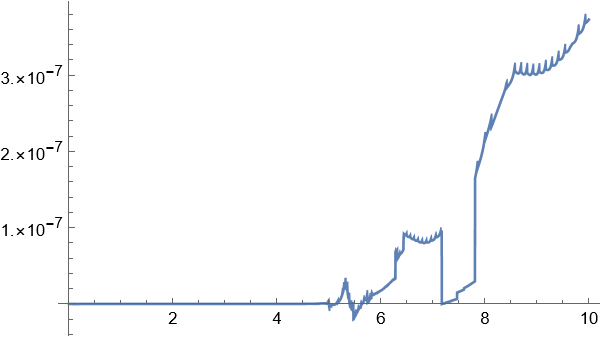

In [46]:
Plot[squaretransmission[e,5,1]-transmission[5&,e,1],{e,0,10}]

## Interesting shapes

Here's some interesting shapes that effectively carve out some of that 5 eV barrier modeled above:

-Graphics-
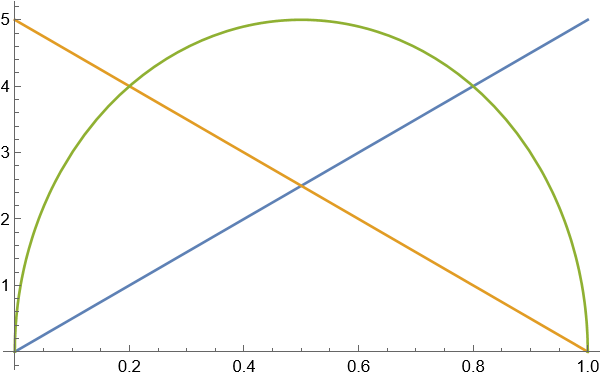

In [47]:
risingTriangle[x_]:=5 x;
fallingTriangle[x_]:=5-5 x;
semiellipse[x_]:=5 Sqrt[1-(x-0.5)^2/.5^2];
Plot[{risingTriangle[x],fallingTriangle[x],semiellipse[x]},{x,0,1}]

STOP! before reading further, try to see if you can predict the results. I haven't even run the results yet, so here are my predictions:

- rising and falling will be the same
- much more tunneling for either rising or falling than the semi-ellipse
- less oscillation for the energies above 5 eV for the rising and falling
- more interesting and fast oscillations above 5 eV for the semi-ellipse.

Let's see just how wrong I am. 

First the rising:

-Graphics-
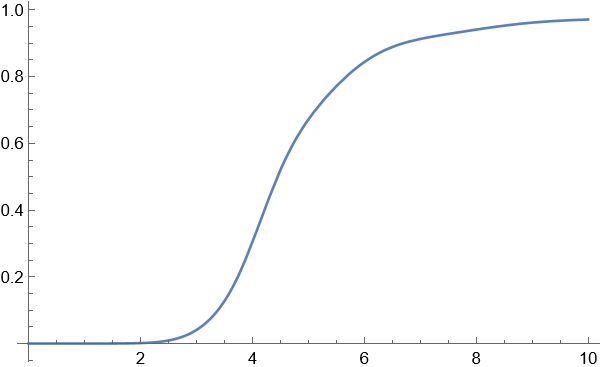

In [51]:
Plot[transmission[risingTriangle, energy, 1], {energy, 0, 10}]

now the falling (remember, I predict it'll look the same):

-Graphics-
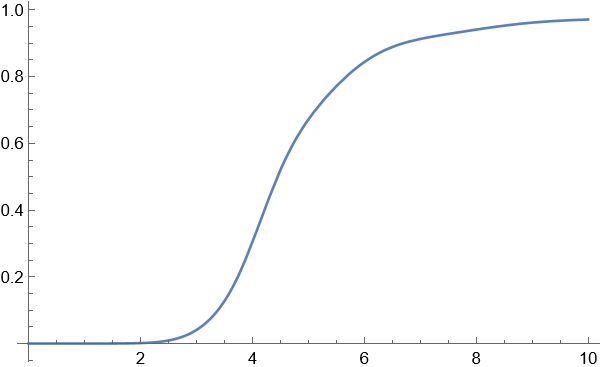

In [52]:
Plot[transmission[fallingTriangle, energy, 1], {energy, 0, 10}]

and now the semi-ellipse:

-Graphics-
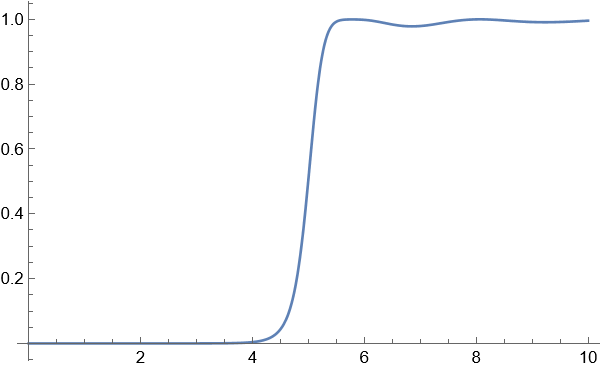

In [53]:
Plot[transmission[semiellipse, energy, 1], {energy, 0, 10}]

Here I put them all on top of each other with the same color scheme as the potential plots above:

-Graphics-
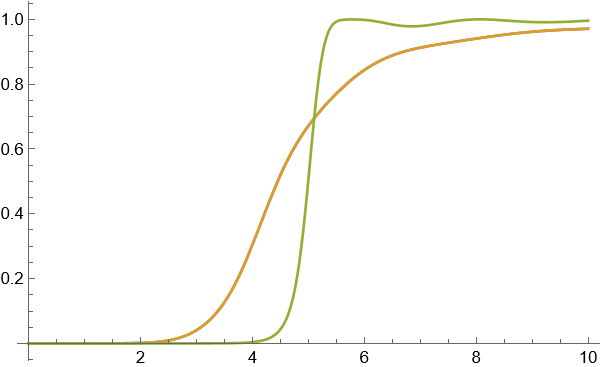

In [56]:
Plot[{transmission[risingTriangle, energy, 1], transmission[fallingTriangle, energy, 1], transmission[semiellipse, energy,1]},
            {energy, 0, 10}]

and here's a plot of the difference between rising and falling:

-Graphics-
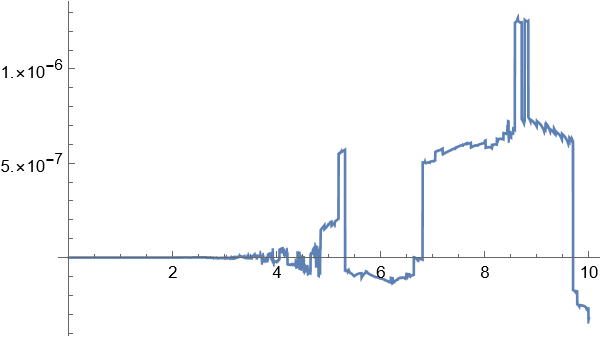

In [57]:
Plot[transmission[risingTriangle, energy, 1]-transmission[fallingTriangle, energy, 1], {energy, 0,10}]

My predictions? Pretty good! I nailed the first one (rising and falling give same result) and the second one (much more transmission for the rising and falling), and the third one (very little oscillations), and sort of got my third one (more interesting oscillations for the semicircle). 

What about you?

Ok, one more (inspired by the additional study I put in that [earlier blog post](https://arundquist.wordpress.com/2020/08/15/fast-quantum-tunneling-method/)):

-Graphics-
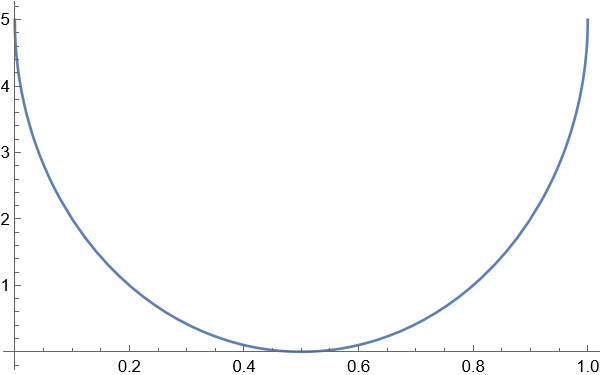

In [60]:
carvedOutSemiellipse[x_]:=5-semiellipse[x];
Plot[carvedOutSemiellipse[x],{x,0,1}]

Predictions? I think we'll see a lot of resonant phenomena, but the lower peaks will be so skinny that Mathematica will skip them unless I really make it work.

-Graphics-
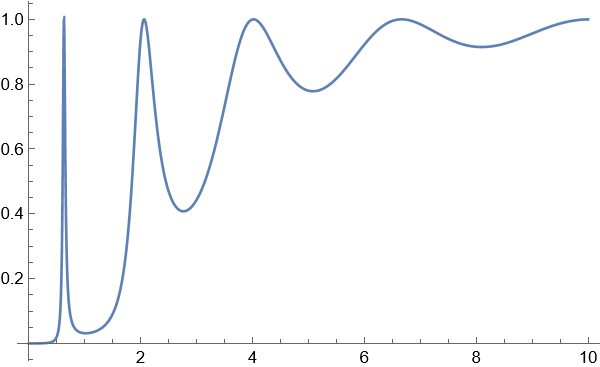

In [62]:
Plot[transmission[carvedOutSemiellipse, energy, 1], {energy, 0, 10}]

Hmm. I guess there's only one resonant energy. That should be related to how many half-wavelengths fit inside, I would think. What energy would have a half wavelength of 1 nm?

In [64]:
Solve[2. Pi/k[energy]/2==1, energy]

{{energy -> 0.374784}}

Hmmm. Let's see where that one sharp peak is (I have to do this transSolve trick forcing the argument to be real or else FindMaximum fails since it tries to execute the function with symbolic entries and my transmission function can't handle that).

In [68]:
transSolve[e_Real]:=transmission[carvedOutSemiellipse, e, 1];
FindMaximum[transSolve[e],{e,0.6}]

FindMaximum::lstol: The line search decreased the step size to within the tolerance specified by AccuracyGoal and PrecisionGoal but was unable to find a sufficient increase in the function. You may need more than MachinePrecision digits of working precision to meet these tolerances.

{1., {e -> 0.630928}}

Here's a plot showing there that energy is on the potential curve:

-Graphics-
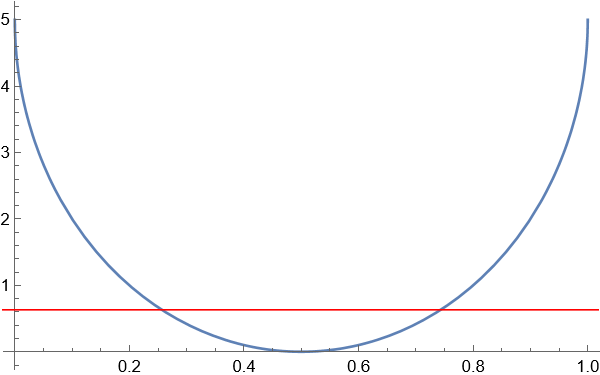

In [70]:
Plot[carvedOutSemiellipse[x], {x,0,1}, Epilog->{Red, InfiniteLine[{0,0.630928},{1,0}]}]

Here's a plot of the real and imaginary parts of the wavefunction at that energy:

-Graphics-
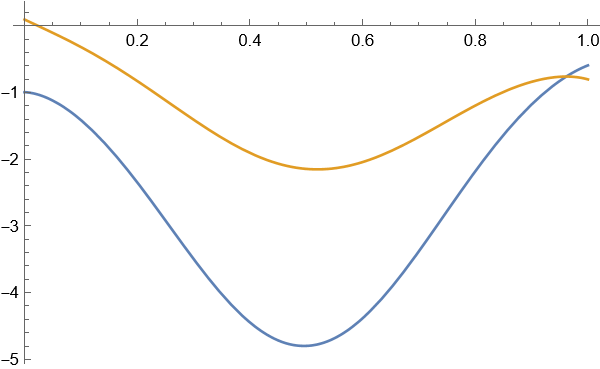

In [77]:
transmission[carvedOutSemiellipse,0.630928,1];
Plot[{Re[psi[x]]/.s, Im[psi[x]]/.s},{x,0,1}]

It looks like just one wavelength fits in there, rather than half a wavelength. I guess that makes sense.

Wow, it really does tunnel through quite a bit of the barrier! That also means that, for that energy, there would be no reflection! So you'd throw the electron at that barrier and it would just go right through like it's not there, every time!

## Your thoughts?

I'd love to hear about other regimes you'd like to explore. Note that I know that Disqus forces you to register, and I get that's a hassle. If you'd rather just tweet your thoughts, feel free: @arundquist

- This is cool! I'd love to play around with a potential barrier like . . .
- This is so dumb. Of course you didn't invent this. I saw it first written up . . .
- Why did you post this here instead of you wordpress blog?
- Disqus sucks, you should use this instead: . . .
- Discus is great! What I especially love is . . .
- I see that jupyter doesn't have a built in spell checker
- Wait, you're able to do arbitrary barriers with effectively two lines of code? What wizardry is this?